In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as its
import sys
import time
import os
import string

import tensorflow as tf

import keras
import keras.backend as K
import keras.preprocessing.sequence as pps
import keras.preprocessing.text as ppt
import keras.layers.wrappers as wrappers

#import pandas as pd

histories = dict()


Using TensorFlow backend.


## TODO

- cmp performance with one hot data
- generate text (-> simplify model?)
- use word dataset
- generate text with word dataset ?

In [21]:
tt = ppt.Tokenizer(1) 

tt.fit_on_texts(["hej hej hej då då då", "haha hehe hehe hehe"])
tt.word_index

{'d\xc3\xa5': 2, 'haha': 4, 'hehe': 1, 'hej': 3}

In [48]:

chars_to_keep = string.ascii_lowercase + ' ' + ',' + '.' + '?' +'0' + '1'#+ '!' + '(' + ')' + '/' + ':' + ';' + '\"' + '0' + '1' + '2'
ord_dict = dict(zip(chars_to_keep, 1 + np.arange(len(chars_to_keep), dtype=np.int8)))
char_dict = dict(zip(np.arange(len(chars_to_keep), dtype=np.int8), chars_to_keep))




def string_to_array(s):
    def maybe_char(c):
        if c in chars_to_keep:
            return c
        if c == '-' or c == '_':
            return ' '
        if c == '!':
            return '.'
        if c == ':':
            return ','
        if c in string.digits:
            return '1'
        return ""
    return np.array([ord_dict[c] for c in "".join(map(maybe_char, s.lower()))], np.int8)



def get_data(folder='/Users/anton/Downloads/aclimdb', files_to_use=1.0, max_len=80, train_data=True):
    # Takes the first files_to_use files from both folders and pads to max_len
    
    if train_data:
        folder += '/train'
    else:
        folder += '/test'
        
    X = []
    X_lengths = []
    lengths = []
    sub_folders = ['pos', 'neg']
    for sub_folder in sub_folders:
        path = folder + '/' + sub_folder + "/"
        files = os.listdir(path)
        files = files[:int(len(files)*files_to_use)]
        lengths.append(len(files))

        for fn in files:
            #import IPython.core.debugger as ipdb;ipdb.set_trace()

            try:
                f = file(path + fn, 'r')
                ss = f.read()
            except Exception as e:
                print "Could not open file %s, error: %s %s %s"% (fn, type(e), e.__str__(), sys.exc_info()[0])
            
            X.append(string_to_array(ss))
            X_lengths.append(len(ss))


    X = keras.preprocessing.sequence.pad_sequences(X, max_len)
    y = np.concatenate((np.ones(lengths[0]), np.zeros(lengths[1])))
    
    np.random.seed(7)
    np.random.shuffle(X)
    
    np.random.seed(7)
    np.random.shuffle(y)
    
    return X, y.reshape((y.size,-1)), X_lengths
    

In [59]:
def sentiment_m1():
    n_units_1 = 50

    n_units_2 = 128

    n_characters = len(chars_to_keep)

    dropout_p = 0.2

#    dropout_p = 0.0


    m = keras.models.Sequential()

    one_hot_embedding = np.concatenate((np.zeros((n_characters, 1)), np.eye(n_characters)), axis=1).T


    m.add(keras.layers.Embedding(n_characters + 1, n_characters, mask_zero=True, weights=[one_hot_embedding], trainable=False))

    m.add( wrappers.Bidirectional( keras.layers.LSTM( n_units_1, dropout=dropout_p/2, return_sequences=True ) ))
    #m.add( keras.layers.LSTM( n_units_2, dropout=dropout_p, return_sequences=True ) )
    m.add( keras.layers.LSTM( n_units_2, dropout=dropout_p ) )

    m.add( keras.layers.Dense(1, activation='sigmoid'))

    m.compile('adam', 'binary_crossentropy', metrics=['acc'])
    
    return m

(80,)

In [51]:
X, y, lengths = get_data()



In [12]:
m = sentiment_m1()

(25000, 800)

In [68]:
t0 = time.time()
batch_size = 64
n_epochs = 15

history = m.fit(X, y, epochs=n_epochs, validation_split=0.15, shuffle=False, batch_size=batch_size)
history_list.append(history)
print( "%g[s] elapsed" % (time.time() - t0))


Train on 21250 samples, validate on 3750 samples
Epoch 1/15
21250/21250 [==============================] - 221s - loss: 0.4666 - acc: 0.7671 - val_loss: 0.6770 - val_acc: 0.6640
Epoch 2/15
21250/21250 [==============================] - 219s - loss: 0.4575 - acc: 0.7760 - val_loss: 0.6981 - val_acc: 0.6613
Epoch 3/15
21250/21250 [==============================] - 221s - loss: 0.4555 - acc: 0.7768 - val_loss: 0.6615 - val_acc: 0.6688
Epoch 4/15
21250/21250 [==============================] - 220s - loss: 0.4497 - acc: 0.7779 - val_loss: 0.6731 - val_acc: 0.6603
Epoch 5/15
21250/21250 [==============================] - 219s - loss: 0.4390 - acc: 0.7854 - val_loss: 0.6870 - val_acc: 0.6688
Epoch 6/15
21250/21250 [==============================] - 220s - loss: 0.4372 - acc: 0.7853 - val_loss: 0.6949 - val_acc: 0.6605
Epoch 7/15
21250/21250 [==============================] - 220s - loss: 0.4322 - acc: 0.7907 - val_loss: 0.7039 - val_acc: 0.6661
Epoch 8/15
21250/21250 [========================

array([ 8,  5, 10], dtype=int8)

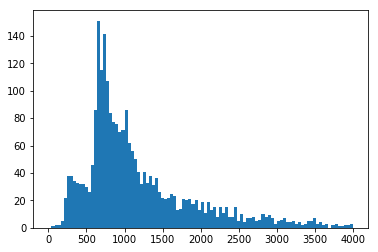

In [16]:
plt.hist(lengths, bins=100, range=(0,4000))
plt.show()

In [181]:
n_characters

32

In [183]:
def generate_text_m1( n_characters ):
    
    n_units = 512

    m = keras.models.Sequential()

    m.add( keras.layers.Embedding(n_characters + 2, n_characters, mask_zero=True) )
    m.add( keras.layers.LSTM(n_units, return_sequences=True))
    m.add( keras.layers.Dropout(0.5))
    m.add( keras.layers.LSTM(n_units, return_sequences=True))
    m.add( keras.layers.Dropout(0.5))
    m.add( keras.layers.Dense(n_characters + 1, activation='softmax') )

    m.compile('adam', loss='sparse_categorical_crossentropy' )


    return m



In [184]:
gen_model = generate_text_m1(len(chars_to_keep))

In [185]:
histories['generate_text_m1'].append(gen_model.fit(X[:, :-1], X[:, 1:, np.newaxis], validation_split=0.10, shuffle=False, batch_size=batch_size, epochs=10 ))



Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 1147s - loss: 2.7249 - val_loss: 2.2298
Epoch 2/10
22500/22500 [==============================] - 1109s - loss: 2.0629 - val_loss: 1.7819
Epoch 3/10
22500/22500 [==============================] - 1056s - loss: 1.7601 - val_loss: 1.5697
Epoch 4/10
22500/22500 [==============================] - 1023s - loss: 1.6121 - val_loss: 1.4639
Epoch 5/10
22500/22500 [==============================] - 1117s - loss: 1.5256 - val_loss: 1.4024
Epoch 6/10
22500/22500 [==============================] - 1161s - loss: 1.4691 - val_loss: 1.3622
Epoch 7/10
22500/22500 [==============================] - 1025s - loss: 1.4304 - val_loss: 1.3375
Epoch 8/10
22500/22500 [==============================] - 1075s - loss: 1.4006 - val_loss: 1.3134
Epoch 9/10
22500/22500 [==============================] - 1087s - loss: 1.3767 - val_loss: 1.2981
Epoch 10/10
22500/22500 [==============================] - 1138s - lo

In [170]:
mm.predict(X[:1, :-1])[:, :, X[0, 1:]].shape

(1, 79, 80)

In [74]:
mm = histories['generate_text_m1'].model

In [119]:
def generate_char(m, text=""):
     return np.random.choice( list(chars_to_keep)+['_'], p=m.predict(string_to_array('hej')[np.newaxis, :])[0, -1]) 

In [120]:
def generate_text(m, N):
    text = ""
    for i in range(N):
        text += generate_char(m, text)
    return text
    

In [153]:
generate_text(mm, 10)

'xpnfvqqppq'

In [126]:
string_to_array('hej')[np.newaxis, :]

array([[ 8,  5, 10]], dtype=int8)

In [124]:
generate_text(mm, '')

TypeError: range() integer end argument expected, got str.

In [112]:
len(chars_to_keep)

32

In [26]:
# model 2:

n_units_1 = 50

n_units_2 = 128

#n_characters = 28
n_characters = len(chars_to_keep)

dropout_p = 0.2

dropout_p = 0.0


m2 = keras.models.Sequential()

one_hot_embedding = np.concatenate((np.zeros((n_characters, 1)), np.eye(n_characters)), axis=1).T

m2.add(keras.layers.Embedding(n_characters + 1, n_characters, mask_zero=True, weights=[one_hot_embedding]))


m2.add( keras.layers.LSTM( n_units_2, dropout=dropout_p/2.0 ) )


m2.add( keras.layers.Dense(1, activation='sigmoid'))

m2.compile('adam', 'binary_crossentropy', metrics=['acc'])



In [27]:

batch_size = 64
n_epochs = 15

history = m2.fit(X, y, epochs=n_epochs, validation_split=0.15, shuffle=False, verbose=2, batch_size=batch_size)




Train on 21250 samples, validate on 3750 samples
Epoch 1/15
1155s - loss: 0.6905 - acc: 0.5287 - val_loss: 0.6899 - val_acc: 0.5213
Epoch 2/15
1138s - loss: 0.6922 - acc: 0.5337 - val_loss: 0.6904 - val_acc: 0.5165
Epoch 3/15
1141s - loss: 0.6859 - acc: 0.5437 - val_loss: 0.6884 - val_acc: 0.5325
Epoch 4/15
1141s - loss: 0.6815 - acc: 0.5569 - val_loss: 0.6881 - val_acc: 0.5283
Epoch 5/15
1139s - loss: 0.6796 - acc: 0.5603 - val_loss: 0.6857 - val_acc: 0.5456
Epoch 6/15
1136s - loss: 0.6857 - acc: 0.5435 - val_loss: 0.6949 - val_acc: 0.5176
Epoch 7/15
1142s - loss: 0.6851 - acc: 0.5469 - val_loss: 0.6917 - val_acc: 0.5285
Epoch 8/15
1142s - loss: 0.6801 - acc: 0.5584 - val_loss: 0.6845 - val_acc: 0.5349
Epoch 9/15
1139s - loss: 0.6760 - acc: 0.5699 - val_loss: 0.6749 - val_acc: 0.5653
Epoch 10/15
1141s - loss: 0.6739 - acc: 0.5713 - val_loss: 0.6814 - val_acc: 0.5403
Epoch 11/15
1144s - loss: 0.6793 - acc: 0.5617 - val_loss: 0.6937 - val_acc: 0.5147
Epoch 12/15
1141s - loss: 0.6934 - a

In [77]:
charss = np.array([-128, -127, -126, -125, -124, -123, -120, -119, -118, -115, -114,
       -111, -109, -107, -106, -105, -104, -103, -102, -100,  -99,  -98,
        -97,  -96,  -95,  -94,  -93,  -92,  -91,  -90,  -89,  -88,  -87,
        -86,  -85,  -84,  -83,  -82,  -81,  -80,  -79,  -78,  -77,  -76,
        -74,  -73,  -72,  -71,  -70,  -69,  -68,  -67,  -66,  -65,  -62,
        -61,  -59,  -30,  -17,    8,    9,   16,   32,   33,   34,   35,
         36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,
         47,   48,   49,   50,   51,   52,   53,   54,   55,   56,   57,
         58,   59,   60,   61,   62,   63,   64,   65,   66,   67,   68,
         69,   70,   71,   72,   73,   74,   75,   76,   77,   78,   79,
         80,   81,   82,   83,   84,   85,   86,   87,   88,   89,   90,
         91,   92,   93,   94,   95,   96,   97,   98,   99,  100,  101,
        102,  103,  104,  105,  106,  107,  108,  109,  110,  111,  112,
        113,  114,  115,  116,  117,  118,  119,  120,  121,  122,  123,
        124,  125,  126])

In [78]:
cc = charss %256

In [80]:
list(map(chr, cc))

['\x80',
 '\x81',
 '\x82',
 '\x83',
 '\x84',
 '\x85',
 '\x88',
 '\x89',
 '\x8a',
 '\x8d',
 '\x8e',
 '\x91',
 '\x93',
 '\x95',
 '\x96',
 '\x97',
 '\x98',
 '\x99',
 '\x9a',
 '\x9c',
 '\x9d',
 '\x9e',
 '\x9f',
 '\xa0',
 '\xa1',
 '\xa2',
 '\xa3',
 '\xa4',
 '\xa5',
 '\xa6',
 '\xa7',
 '\xa8',
 '\xa9',
 '\xaa',
 '\xab',
 '\xac',
 '\xad',
 '\xae',
 '\xaf',
 '\xb0',
 '\xb1',
 '\xb2',
 '\xb3',
 '\xb4',
 '\xb6',
 '\xb7',
 '\xb8',
 '\xb9',
 '\xba',
 '\xbb',
 '\xbc',
 '\xbd',
 '\xbe',
 '\xbf',
 '\xc2',
 '\xc3',
 '\xc5',
 '\xe2',
 '\xef',
 '\x08',
 '\t',
 '\x10',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',